# Citibike Modeling w/ WaveNet + Exogenous Features

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/")

In [ ]:
import numpy as np
import pandas as pd
import pickle
import random
import datetime as dt
from datetime import datetime
from datetime import timedelta
import patsy
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam
import tensorflow
from tensorflow.keras.models import load_model

from helper_functions import mae, mape, rmse, plot_forecast

## Forecast with WaveNet and exogenous features

In [7]:
# read pickled dataframe
citibike_df = pd.read_pickle('data/citibike_df_formatted.pkl') 

In [0]:
# head of dataframe
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts,replace_zeroes,ride_counts_clean
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,3,15,NaN,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,4,22,NaN,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,5,15,NaN,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,6,27,NaN,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,0,27,NaN,27


In [9]:
# create dataframe with dates as columns and stations as rows
df_all = citibike_df.pivot(index='station_id', columns='date', values='ride_counts_clean')
df_all.head()

date,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
station_id,,,,,,,,,,,,,,,,,,,,,
79,15,22,15,27,27,21,16,14,15,14,...,30,52,32,19,36,55,20,19,12,42
119,3,3,3,5,5,4,8,3,4,2,...,6,22,8,5,8,10,19,13,10,9
120,4,1,4,4,4,2,1,1,1,2,...,25,22,20,10,13,26,20,15,8,21
127,41,52,19,33,65,42,45,24,32,29,...,61,79,43,18,48,69,60,44,34,88
128,24,51,13,16,76,38,44,30,41,42,...,77,78,63,21,62,69,77,39,28,81


In [0]:
# subset to only training dates - exclude all of 2019
df = df_all.loc[:, df_all.columns[:(1826-365)]]

In [0]:
# reformat column names
df = df.reset_index()
df = df.rename_axis(None)
df.columns = df.columns.astype(str)
df.columns = df.columns.astype(str).str.replace(' 00:00:00', '')

In [0]:
# head of dataframe
df.head()

date,station_id,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,2015-01-11,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-17,2015-01-18,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-24,2015-01-25,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-01-31,2015-02-01,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-07,2015-02-08,...,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31
0,79,15,22,15,27,27,21,16,14,15,14,15,17,34,21,29,33,17,3,15,25,31,28,36,5,24,7,19,8,14,12,6,14,5,7,14,12,12,7,8,...,8,18,28,60,27,60,62,79,65,52,29,74,62,67,60,75,43,43,59,79,71,59,63,60,17,60,49,64,40,40,35,33,26,18,27,32,9,18,21,24
1,119,3,3,3,5,5,4,8,3,4,2,3,4,4,6,5,5,1,4,2,8,7,7,5,4,4,5,1,1,5,5,3,1,1,2,4,4,4,3,1,...,1,3,5,2,4,9,5,9,16,3,3,13,13,11,8,8,6,6,10,13,14,12,10,3,1,10,11,6,11,2,6,7,7,2,2,3,2,8,4,3
2,120,4,1,4,4,4,2,1,1,1,2,3,2,6,3,5,4,8,3,9,6,1,9,6,6,7,3,4,2,2,1,3,2,2,1,4,1,2,5,6,...,11,14,25,29,16,12,19,19,27,22,17,27,32,21,29,24,26,27,20,20,25,20,37,28,10,16,22,18,11,13,21,8,7,6,12,8,4,27,15,10
3,127,41,52,19,33,65,42,45,24,32,29,31,38,67,60,68,60,39,6,61,93,61,81,78,26,52,21,7,33,40,34,21,32,5,28,32,50,34,28,30,...,15,36,37,78,114,179,189,185,175,117,60,194,156,136,171,154,79,73,137,180,198,144,179,110,19,165,167,160,117,73,54,51,42,26,55,71,34,52,52,35
4,128,24,51,13,16,76,38,44,30,41,42,36,44,74,61,68,78,46,2,64,86,89,86,88,26,48,26,13,27,21,41,34,36,7,27,55,38,41,43,35,...,23,33,63,92,85,170,158,163,141,149,59,167,166,143,168,138,72,77,126,150,143,130,125,117,25,124,120,122,94,56,58,54,41,27,49,74,31,75,43,46


In [0]:
# add exogenous feature - day of the week
dow_ohe = pd.get_dummies(pd.to_datetime(df.columns[1:]).dayofweek)
dow_ohe.head(5)

,0,1,2,3,4,5,6
0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0


In [0]:
dow_array = np.expand_dims(dow_ohe.values, axis=0) # add sample dimension
dow_array = np.tile(dow_array,(df.shape[0],1,1)) # repeat OHE array along sample dimension
dow_array.shape

(182, 1461, 7)

In [0]:
# add exogenous feature - month of the year 
moy_ohe = pd.get_dummies(pd.to_datetime(df.columns[1:]).month)
moy_ohe.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
moy_array = np.expand_dims(moy_ohe.values, axis=0) # add sample dimension
moy_array = np.tile(moy_array,(df.shape[0],1,1)) # repeat OHE array along sample dimension
moy_array.shape

(182, 1461, 12)

In [0]:
df.head()

date,station_id,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,2015-01-11,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-17,2015-01-18,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-24,2015-01-25,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-01-31,2015-02-01,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-07,2015-02-08,...,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31
0,79,15,22,15,27,27,21,16,14,15,14,15,17,34,21,29,33,17,3,15,25,31,28,36,5,24,7,19,8,14,12,6,14,5,7,14,12,12,7,8,...,8,18,28,60,27,60,62,79,65,52,29,74,62,67,60,75,43,43,59,79,71,59,63,60,17,60,49,64,40,40,35,33,26,18,27,32,9,18,21,24
1,119,3,3,3,5,5,4,8,3,4,2,3,4,4,6,5,5,1,4,2,8,7,7,5,4,4,5,1,1,5,5,3,1,1,2,4,4,4,3,1,...,1,3,5,2,4,9,5,9,16,3,3,13,13,11,8,8,6,6,10,13,14,12,10,3,1,10,11,6,11,2,6,7,7,2,2,3,2,8,4,3
2,120,4,1,4,4,4,2,1,1,1,2,3,2,6,3,5,4,8,3,9,6,1,9,6,6,7,3,4,2,2,1,3,2,2,1,4,1,2,5,6,...,11,14,25,29,16,12,19,19,27,22,17,27,32,21,29,24,26,27,20,20,25,20,37,28,10,16,22,18,11,13,21,8,7,6,12,8,4,27,15,10
3,127,41,52,19,33,65,42,45,24,32,29,31,38,67,60,68,60,39,6,61,93,61,81,78,26,52,21,7,33,40,34,21,32,5,28,32,50,34,28,30,...,15,36,37,78,114,179,189,185,175,117,60,194,156,136,171,154,79,73,137,180,198,144,179,110,19,165,167,160,117,73,54,51,42,26,55,71,34,52,52,35
4,128,24,51,13,16,76,38,44,30,41,42,36,44,74,61,68,78,46,2,64,86,89,86,88,26,48,26,13,27,21,41,34,36,7,27,55,38,41,43,35,...,23,33,63,92,85,170,158,163,141,149,59,167,166,143,168,138,72,77,126,150,143,130,125,117,25,124,120,122,94,56,58,54,41,27,49,74,31,75,43,46


In [0]:
# concatenate the day of week and month of year info into one shared array
exog_array = np.concatenate([dow_array, moy_array], axis=-1)
exog_array.shape

(182, 1461, 19)

In [0]:
# date range of training data
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-01-01 to 2018-12-31


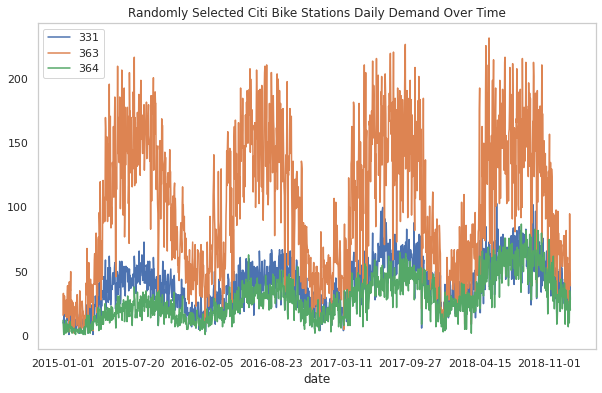

In [0]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=24)
    station_labels = sample['station_id'].tolist()
    series_samples = sample.loc[:, data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        (pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Citi Bike Stations Daily Demand Over Time')
    plt.legend(station_labels)
    
plot_random_series(df, 3)

### Train and Validation Series Partioning

**Create 4 sub-segments of the data:**.   
1. Train encoding period  
2. Train decoding period (train targets, 60 days)  
3. Validation encoding period  
4. Validation decoding period (validation targets, 60 days)  

In [0]:
print(data_start_date, "to", data_end_date)

2015-01-01 to 2018-12-31


In [0]:
pred_steps = 365 
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date) # gradually increase start end date (for overlapping windows)?

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [0]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [0]:
print('Train encoding:', train_enc_start.strftime('%Y-%m-%d'), 'to', train_enc_end.strftime('%Y-%m-%d'))
print('Train prediction:', train_pred_start.strftime('%Y-%m-%d'), 'to', train_pred_end.strftime('%Y-%m-%d'))
print('\nVal encoding:', val_enc_start.strftime('%Y-%m-%d'), 'to', val_enc_end.strftime('%Y-%m-%d'))
print('Val prediction:', val_pred_start.strftime('%Y-%m-%d'), 'to', val_pred_end.strftime('%Y-%m-%d'))

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-01-01 to 2016-12-31
Train prediction: 2017-01-01 to 2017-12-31

Val encoding: 2016-01-01 to 2017-12-31
Val prediction: 2018-01-01 to 2018-12-31

Encoding interval: 731
Prediction interval: 365


**Keras data formatting**

In [0]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])                          

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):

    inds = date_to_index[start_date:end_date]
    return series_array[:, inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0], series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0], series_array.shape[1], 1))
    
    return series_array

In [0]:
# function for extracting encoder/input data (with the correct exogenous features attached) and decoder/target data
def get_data_encode_decode(series_array, exog_array, first_n_samples,
                           date_to_index, enc_start, enc_end, pred_start, pred_end):

    exog_inds = date_to_index[enc_start:pred_end]
    
    # sample of series from enc_start to enc_end  
    encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                               enc_start, enc_end)[:first_n_samples]
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    # sample of series from pred_start to pred_end 
    decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                                pred_start, pred_end)[:first_n_samples]
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    # we append a lagged history of the target series to the input data, 
    # so that we can train with teacher forcing
    lagged_target_history = decoder_target_data[:,:-1,:1]
    encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)
    
    # we add the exogenous features corresponding to day after input series
    # values to the input data (exog should match day we are predicting)
    exog_input_data = exog_array[:first_n_samples,exog_inds,:][:,1:,:]
    encoder_input_data = np.concatenate([encoder_input_data, exog_input_data], axis=-1)
    
    return encoder_input_data, decoder_target_data, encode_series_mean

### CNN setup

In [0]:
# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
# note the feature input dimension corresponds to the raw series and all exogenous features  
history_seq = Input(shape=(None, 1 + exog_array.shape[-1]))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(32, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(32, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 365 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':365})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [61]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, 20)     0                                            
__________________________________________________________________________________________________
conv1d_199 (Conv1D)             (None, None, 32)     672         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_200 (Conv1D)             (None, None, 32)     2080        conv1d_199[0][0]                 
__________________________________________________________________________________________________
conv1d_201 (Conv1D)             (None, None, 32)     2080        conv1d_199[0][0]                 
____________________________________________________________________________________________

### Fit and train the model

In [0]:
# define early stopping with tensorflow
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=15, verbose=0, mode='auto', #val_loss
    baseline=None, restore_best_weights=False
)

In [63]:
exog_array.shape

(182, 1461, 19)

In [64]:
# set number of epochs
first_n_samples = df.shape[0]
batch_size = 2**10
epochs = 1000 # 100, 10

#encoder_input_data, decoder_target_data = get_data_encode_decode(series_array, exog_array, first_n_samples, date_to_index, 
#                                                                 train_enc_start, train_enc_end, train_pred_start, train_pred_end)
#

# testing the addition of encode series mean here
encoder_input_data, decoder_target_data, encode_series_mean = get_data_encode_decode(series_array, exog_array, first_n_samples, date_to_index, 
                                                                 train_enc_start, train_enc_end, train_pred_start, train_pred_end)

## sample of series from train_enc_start to train_enc_end  
#encoder_input_data = get_time_block_series(series_array, date_to_index, 
#                                           train_enc_start, train_enc_end)[:first_n_samples]
#encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
#decoder_target_data = get_time_block_series(series_array, date_to_index, 
#                                            train_pred_start, train_pred_end)[:first_n_samples]
#decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

## we append a lagged history of the target series to the input data, so that we can train with teacher forcing
#lagged_target_history = decoder_target_data[:,:-1,:1]
#encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    #validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/1000
182/182 [==============================] - 6s 31ms/step - loss: 0.4923
Epoch 2/1000
182/182 [==============================] - 1s 4ms/step - loss: 0.4856
Epoch 3/1000
182/182 [==============================] - 1s 4ms/step - loss: 0.4495
Epoch 4/1000
182/182 [==============================] - 1s 4ms/step - loss: 0.4351
Epoch 5/1000
182/182 [==============================] - 1s 4ms/step - loss: 0.4224
Epoch 6/1000
182/182 [==============================] - 1s 3ms/step - loss: 0.4047
Epoch 7/1000
182/182 [==============================] - 1s 3ms/step - loss: 0.3926
Epoch 8/1000
182/182 [==============================] - 1s 3ms/step - loss: 0.3836
Epoch 9/1000
182/182 [==============================] - 1s 3ms/step - loss: 0.3713
Epoch 10/1000
182/182 [==============================] - 1s 4ms/step - loss: 0.3604
Epoch 11/1000
182/182 [==============================] - 1s 4ms/step - loss: 0.3546
Epoch 12/1000
182/182 [==============================] - 1s 4ms/step - loss: 0.3486


In [0]:
# save trained model

# creates a HDF5 file 'my_model.h5'
model.save('wavenet_exog') 

# deletes the existing model
#del model  

# returns a compiled model identical to the previous one
#model = load_model('wavenet_exog') # wavenet_1000_epochs.h5 # wavenet_100_epochs

# check its architecture
#model.summary()

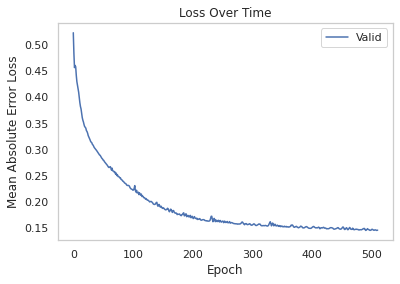

In [0]:
# plot convergence curve of train / validation loss - 1000 EPOCHS (511/1000, loss: 0.1460)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
#plt.legend(['Train','Valid']);
plt.legend(['Valid']);

### Prepare to generate predictions

In [0]:
# get and transform encoder and decoder data for both input and target

#encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
#encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
#
#decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
#decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [0]:
# set history/target series pairs that we didn't train on
# we'll pull out our set of validation encoder/target series - recall that these are shifted forward in time

#encoder_input_data, decoder_target_data = get_data_encode_decode(series_array, exog_array, df.shape[0], date_to_index, 
#                                                                 val_enc_start, val_enc_end, val_pred_start, val_pred_end)

# testing the addition of encode series mean here
encoder_input_data, decoder_target_data, encode_series_mean = get_data_encode_decode(series_array, exog_array, df.shape[0], date_to_index, 
                                                                                     val_enc_start, val_enc_end, val_pred_start, val_pred_end)

In [0]:
# function to generate predictions by running our model with inference loop
def predict_sequence(input_tensor):

    history_tensor = input_tensor[:,:(-pred_steps+1),:]
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_tensor)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction along with corresponding exogenous features
        # to the history tensor
        last_step_exog = input_tensor[:,[(-pred_steps+1)+i],1:]
        last_step_tensor = np.concatenate([last_step_pred.reshape((1,1,1)), 
                                           last_step_exog], axis=-1)
        history_tensor = np.concatenate([history_tensor, last_step_tensor], axis=1)

    return pred_sequence

In [0]:
# function to add encode series mean back to encoder input data, then take inverse logp
def inverse_transform(encoder_input_data, encode_series_mean):
    encode_series_mean = np.expand_dims(encode_series_mean, axis=1)
    encoder_input_data = np.add(encoder_input_data, encode_series_mean)
    encoder_input_data = np.expm1(encoder_input_data) 
    return encoder_input_data

### Forecast select stations

In [10]:
#stations 491, 379 and 499
print("index for station 491:", df_all.index.get_loc(491))
print("index for station 379:", df_all.index.get_loc(379))
print("index for station 499:", df_all.index.get_loc(499))

index for station 491: 153
index for station 379: 98
index for station 499: 158


#### E 24 St & Park Ave S

MAE:  98.14963053256699
MAPE:  45.6467233522247
RMSE:  139.29228377711638


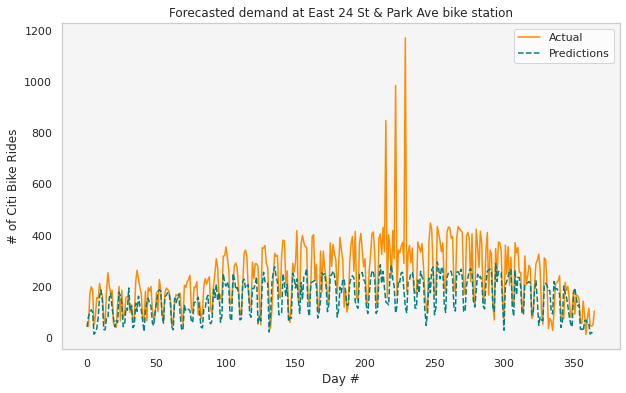

In [66]:
# CNN model: calculate and plot predictions vs actual for station 491 (index 153)
encode_series = encoder_input_data[153:153+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[153]).squeeze()
y_actual = df_all.iloc[153,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at East 24 St & Park Ave bike station')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred)) #.round(5))
print('MAPE: ', mape(y_actual, y_pred)) #.round(5))
print('RMSE: ', rmse(y_actual, y_pred)) #.round(5))     

#### W 31 St 7 Ave

MAE:  75.92672082920404
MAPE:  41.341383929914684
RMSE:  96.3335996343004


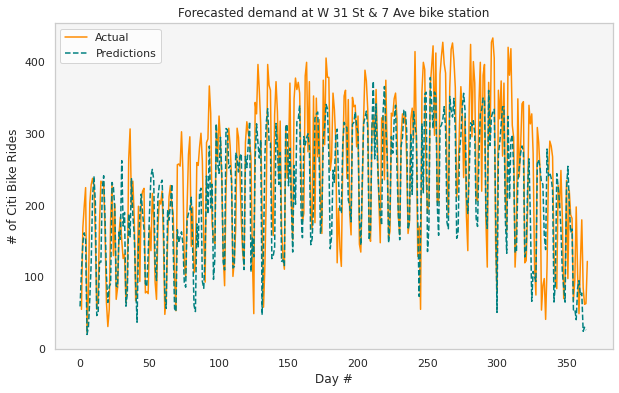

In [67]:
# CNN model: calculate and plot predictions vs actual for station 379 (index 98) 
encode_series = encoder_input_data[98:98+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[98]).squeeze()
y_actual = df_all.iloc[98,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at W 31 St & 7 Ave bike station')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred)) #.round(5))
print('MAPE: ', mape(y_actual, y_pred)) #.round(5))
print('RMSE: ', rmse(y_actual, y_pred)) #.round(5))     

#### Broadway & W 60 St

MAE:  107.92921820202302
MAPE:  55.82414202111834
RMSE:  132.375786283312


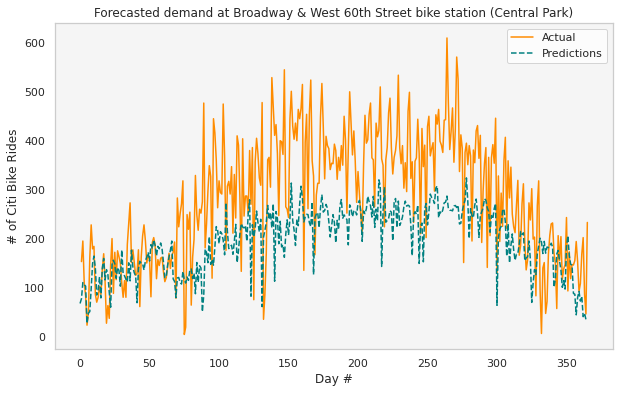

In [69]:
# CNN model: calculate and plot predictions vs actual for station 499 (index 158)
encode_series = encoder_input_data[158:158+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[158]).squeeze()
y_actual = df_all.iloc[158,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at Broadway & West 60th Street bike station (Central Park)')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred)) #.round(5))
print('MAPE: ', mape(y_actual, y_pred)) #.round(5))
print('RMSE: ', rmse(y_actual, y_pred)) #.round(5))     

### Forecast all stations

In [73]:
# CNN model: calculate predictions and avg mae / mape for all 182 stations

y_preds = {}
y_actuals = {}

mape_dict = {}
mae_dict = {}
rmse_dict = {}

for index in range(182): 
  encode_series = encoder_input_data[index:index+1,:,:]
  pred_series = predict_sequence(encode_series)
  y_pred = inverse_transform(pred_series, encode_series_mean[index]).squeeze()
  y_actual = df_all.iloc[index,-365:]

  # store predictions and actuals
  y_preds[index] = y_pred
  y_actuals[index] = y_actual

  # evaluation metrics
  mape_dict[index] = mape(y_actual, y_pred)
  mae_dict[index] = mae(y_actual, y_pred)
  rmse_dict[index] = rmse(y_actual, y_pred)
  
print('Mean MAPE: ', np.array(list(mape_dict.values())).mean()) #.round(5))  
print('Mean MAE: ', np.array(list(mae_dict.values())).mean()) #.round(5))
print('Mean RMSE: ', np.array(list(rmse_dict.values())).mean()) #.round(5))   

Mean MAPE:  43.21286753613623
Mean MAE:  38.21348953674399
Mean RMSE:  48.553440170168386
